In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import SearchIO
import csv
import sqlite3
import time
from multiprocessing import Pool, cpu_count
import sys
from calc_icity_ import *
import ast
from collections import defaultdict

In [2]:
tnpBs_list = []
infile_tnpBs = "tnpBs_in_testdb.p100.1e4.txt"
with open(infile_tnpBs, "r") as infile:
    lines = infile.readlines()
    for line in lines:
        p100 = line.split('\n')[0]
        tnpBs_list.append(p100)
tnpBs_set = set(tnpBs_list)
len(tnpBs_list), len(tnpBs_set)

(55599, 55599)

In [3]:
tnpB_10_target_annot_df = pd.read_csv("tnpB_targetgenes_pfam.csv").iloc[:,1:]

In [4]:
tnpB_10_target_annot_df.shape

(1659, 11)

In [5]:
high_icity_tnpBs_ls = []
for baitp100s_str in tnpB_10_target_annot_df["baitp100s"]:
    baitp100s_ls = ast.literal_eval(baitp100s_str)
    high_icity_tnpBs_ls += baitp100s_ls
high_icity_tnpBs = [tnpB for tnpB in high_icity_tnpBs_ls if tnpB in tnpBs_set]
high_icity_tnpBs_set = set(high_icity_tnpBs)


## get representative tnpBs (p60s) to align

In [6]:
def get_prot_sequence(pid):
    con=sqlite3.connect("80kprotein_stats.db")
    cur = con.cursor()
    cmd = "SELECT sequence FROM proteins WHERE pid = '%s'" % pid 
    #print(cmd)
    cur.execute(cmd)
    return str(cur.fetchone()[0])
    con.close()
def get_faas_protidlist(protidlist, outfile_path):
    with open(outfile_path, "w") as outfile:
        for protid in protidlist:
            protseq = get_prot_sequence(protid)
            print(">" + protid, file=outfile)
            print(protseq, file=outfile)
#get_faas_protidlist(tnpBs_list, "INPUT/tnpB_mmseqs_input.faa")

In [7]:
tnpB_p60s_path = "../tnpBs/cluster/OUTPUT/tmp/clu_cluster.tsv"
tnpB_p60_df = pd.read_csv(tnpB_p60s_path, sep = '\t', header = None).rename(columns = {0:"p60",1:'p100'}).drop_duplicates()

In [8]:
tnpB_p60_df_samp = tnpB_p60_df
tnpB_p60_list_samp = list(set(tnpB_p60_df_samp['p60']))
tnpB_p60_highicity_list = [p60 for p60 in tnpB_p60_list_samp if p60 in high_icity_tnpBs_set]

In [9]:
len(high_icity_tnpBs_set), len(tnpBs_list)

(4977, 55599)

In [10]:
len(tnpB_p60_highicity_list), len(tnpB_p60_df)

(1129, 78873)

In [11]:
def get_faas_protidlist(protidlist):
    for protid in protidlist:
        outfile_path = "../tnpBs/representatives/" + protid + ".faa"
        with open(outfile_path, "w") as outfile:
            protseq = get_prot_sequence(protid)
            if len(protseq) > 300:
                print(">" + protid, file=outfile)
                print(protseq, file=outfile)
#get_faas_protidlist(tnpB_p60_highicity_list)

(array([ 44., 121., 157., 250., 178., 179., 126.,  77.,  91.,  71.]),
 array([ 47. ,  91.9, 136.8, 181.7, 226.6, 271.5, 316.4, 361.3, 406.2,
        451.1, 496. ]),
 <BarContainer object of 10 artists>)

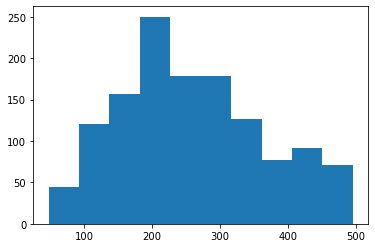

In [12]:
plt.hist(tnpB_10_target_annot_df[tnpB_10_target_annot_df['target_length'] < 500]['target_length'])

### run alignments and get catalytically inactive tnpBs

In [13]:
len(tnpB_p60_highicity_list)

1129

In [19]:
def get_multifaa_protidlist(protidlist):
    outfile_path = "../tnpBs/representatives/_all_tnpBs_muscle_input.faa"
    with open(outfile_path, "w") as outfile:
        for protid in protidlist:
            protseq = get_prot_sequence(protid)
            if len(protseq) > 300 and len(protseq) < 500:
                print(">" + protid, file=outfile)
                print(protseq, file=outfile)
get_multifaa_protidlist(tnpB_p60_highicity_list)

In [46]:
cmd_mafft = "ginsi --thread 32 ../tnpBs/representatives/_all_tnpBs_muscle_input.faa > ../tnpBs/representatives/_all_tnpBs_mafft.out.faa"
#os.system(cmd_mafft)

In [35]:
ref_tnpB_pid = '0fea0aedf485f57c86'
seq1 = get_prot_sequence(ref_tnpB_pid)
seq1[187], seq1[271], seq1[354]

('D', 'E', 'D')

In [40]:
with open("../tnpBs/representatives/_all_tnpBs_mafft.out.faa") as handle:
    for rec in SeqIO.parse(handle, 'fasta'):
        pid = rec.id
        if pid == ref_tnpB_pid:
            seq2 = str(rec.seq)
            break

In [43]:
def get_alignindices_dict(seq1, seq2):
    index_to_alignindex = {}
    align_indexes = []
    for i in range(len(seq2)):
        char = seq2[i]
        if char != '-':
            align_indexes.append(i)
    for j in range(len(align_indexes)):
        index_to_alignindex[j] = align_indexes[j]
    return index_to_alignindex

align_indices_dict = get_alignindices_dict(seq1, seq2)

In [ ]:
with open("../tnpBs/representatives/_all_tnpBs_mafft.out.faa") as handle:
    for rec in SeqIO.parse(handle, 'fasta'):
        pid = rec.id
        if pid == ref_tnpB_pid:
            seq2 = str(rec.seq)
            break

In [44]:
seq2[align_indices_dict[187]], seq2[align_indices_dict[271]], seq2[align_indices_dict[354]]

('D', 'E', 'D')

In [47]:
count_3, count_2, count_1, count_0 = 0, 0, 0, 0

In [51]:
with open("../tnpBs/representatives/_all_tnpBs_mafft.out.faa") as handle, \
open ("../tnpBs/_inactive_tnpBs.faa", "w") as outfile:
    for rec in SeqIO.parse(handle, 'fasta'):
        sequence = rec.seq
        pid = rec.id
        first_residue_missing = sequence[align_indices_dict[187]] != 'D'
        second_residue_missing = sequence[align_indices_dict[271]] != 'E'
        third_residue_missing = sequence[align_indices_dict[354]] != 'D'
        num_res_missing = first_residue_missing + second_residue_missing + third_residue_missing 
        if num_res_missing == 3:
            print(">" + pid, file = outfile)
            sequence_gapfree = get_prot_sequence(pid)
            print(sequence_gapfree, file = outfile)
            count_3 += 1
        elif num_res_missing == 2:
            count_2 += 1
        elif num_res_missing == 1:
            count_1 += 1
        elif num_res_missing == 0:
            count_0 += 1

In [53]:
count_3, count_2, count_1, count_0

(15, 24, 153, 367)

In [59]:
p30_inactive_list = []
with open("../tnpBs/_inactive_tnpBs.faa") as handle:
    for rec in SeqIO.parse(handle, 'fasta'):
        p30_inactive = get_permissive_rep(rec.id)
        p30_inactive_list.append(p30_inactive)
p30_inactive_list.sort()
p30_inactive_list

['14bc66ab7912db1e07',
 '14bc66ab7912db1e07',
 '15ce911abbf167916e',
 '1745b64944eaf24e7d',
 '199f6fcd868299f952',
 '4ca2541634b8270ca0',
 '4ca2541634b8270ca0',
 '544d19bbbb28945456',
 '55da22e58a862b21b0',
 '6e87489ba377373838',
 '6e87489ba377373838',
 '993ea08c331aa195bb',
 'b8218de8a485c7b37f',
 'c328360c354617b7a9',
 'f6e74b8eea638f8073']

In [66]:
'15ce911abbf167916e' in high_icity_tnpBs_set

True